In [2]:
# ================================
# Initialisierung für 6.3 Structural Alignment
# ================================

import pandas as pd
import numpy as np
from pathlib import Path

# Farbdefinitionen für Plots
party_colors = {
    "CDU/CSU": "#000000",
    "AfD": "#0056FF",
    "SPD": "#E3000F",
    "B90/GRÜNE": "#1FA12E",
    "LINKE": "#A3488A",
    "BSW": "#D77AFF",
    "FDP": "#FFED00",
    "FW": "#FF9900",
    "Sonstige": "#B0B0B0"
}

# Daten laden
DATA_PATH1 = r"E:\Final_Github_1\MasterThesis_final\data\processed\preprocessing\mirror\mirror_llama_final.csv"
DATA_PATH2 = r"E:\Final_Github_1\MasterThesis_final\data\processed\preprocessing\augmentation\augmentation_llama_final.csv"

df_mirror = pd.read_csv(DATA_PATH1, sep=";", encoding="utf-8-sig", dtype={"timestamp": str})
df_aug    = pd.read_csv(DATA_PATH2, sep=";", encoding="utf-8-sig", dtype={"timestamp": str})

# CDU/CSU normalisieren
cdu_variants = ["CDU", "CSU", "CDU/CSU"]
for df in [df_mirror, df_aug]:
    if "party" in df.columns:
        df["party"] = df["party"].replace(cdu_variants, "CDU/CSU")

# Daten kombinieren
df_all = pd.concat([df_mirror, df_aug], ignore_index=True)

# Erwartete Kernspalten für 6.3:
# username (user_id), party, interaction_party, pred (stance), n_tweets
if "n_tweets" not in df_all.columns:
    user_counts = df_all.groupby("username").size().reset_index(name="n_tweets")
    df_all = df_all.merge(user_counts, on="username", how="left")

# Output-Pfad definieren
EXPORT_PATH = Path(r"E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3")
EXPORT_PATH.mkdir(parents=True, exist_ok=True)

print("✅ Initialisierung abgeschlossen")
print("Shape Gesamt:", df_all.shape)
print("Beispielspalten:", df_all.columns.tolist()[:10])
print(df_all.head(3))
print("Export-Pfad:", EXPORT_PATH)


✅ Initialisierung abgeschlossen
Shape Gesamt: (1265804, 15)
Beispielspalten: ['tweet_id', 'username', 'X_handle', 'name', 'timestamp', 'party', 'tweet_text', 'pred', 'pred_short', 'raw']
                           tweet_id        username   X_handle  \
0  5db02195065a5bfb8f78b64f3ee9029e     @konrad_flo  ABaerbock   
1  a3fe4ee79dcb56d6843bc40bfe7f061c     @8_dennis_2  ABaerbock   
2  9be69ce59eea51559a1f63a11f3ffc51  @lebensretter3  ABaerbock   

                                name                   timestamp      party  \
0  Baerbock, Annalena Charlotte Alma  Sep 4, 2024 · 11:56 PM UTC  B90/GRÜNE   
1  Baerbock, Annalena Charlotte Alma  Sep 4, 2024 · 11:53 PM UTC  B90/GRÜNE   
2  Baerbock, Annalena Charlotte Alma  Sep 4, 2024 · 11:50 PM UTC  B90/GRÜNE   

                                          tweet_text       pred pred_short  \
0  Hää?? Ja was glauben Sie denn was in einem Kri...  Ablehnung         Ab   
1  Ich bin sicher, dass dieser Unterschied gemach...    Neutral         Ne 

Assigned Users insgesamt: 10025

Cross-Partisan Index (CPI) pro Partei:


,user_party,total_interactions,cross_interactions,CPI
6,SPD,11161,7009,0.627990
4,FDP,35470,22161,0.624782
1,B90/GRÜNE,98588,60992,0.618655
5,LINKE,11763,7220,0.613789
0,AfD,84711,51980,0.613616
2,BSW,11612,6080,0.523596
3,CDU/CSU,160686,78570,0.488966


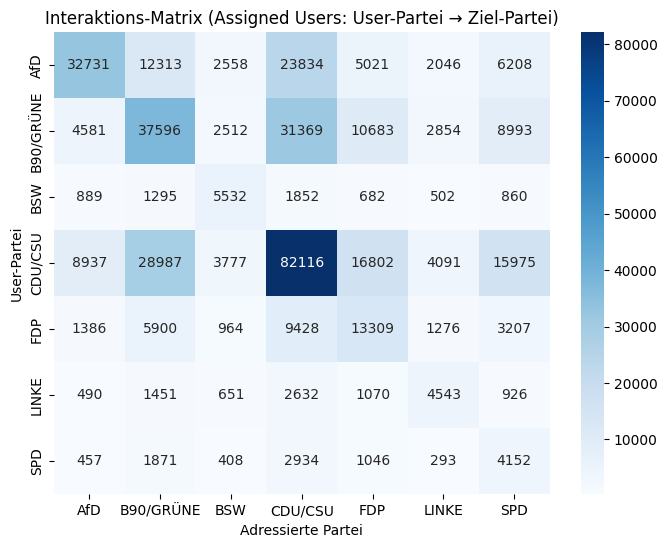

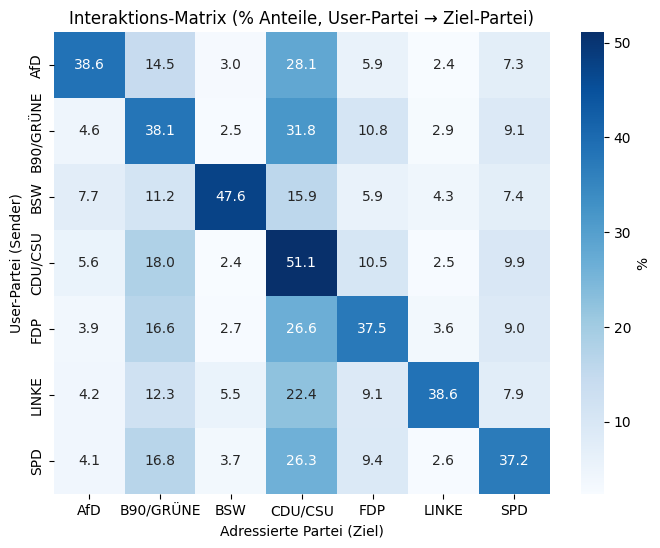

[OK] CPI gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\cpi_per_party.csv
[OK] Matrix gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\interaction_matrix.csv
[OK] Matrix (%) gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\interaction_matrix_percent.csv
[OK] Heatmaps gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\heatmap_counts.png, E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\heatmap_percent.png


In [3]:
# ============================================
# Assigned Users (ASI) + Cross-Partisan Index (CPI) + Heatmap
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Zustimmung-Tweets filtern
df_support = df_all[df_all["pred"] == "Zustimmung"]

# 2. Zustimmung pro User und Partei zählen
user_party_counts = (
    df_support.groupby(["username", "party"])
    .size()
    .reset_index(name="support_count")
)

# 3. Nur User mit ≥3 Zustimmungen (ASI-Definition)
user_party_assigned = user_party_counts[user_party_counts["support_count"] >= 3]

# 4. Jeder User → Partei mit den meisten Zustimmungen
user_max_party = (
    user_party_assigned.sort_values(["username", "support_count"], ascending=[True, False])
    .drop_duplicates(subset="username", keep="first")
)

# 5. Liste eindeutig zugewiesener User
assigned_users = user_max_party.rename(columns={"party": "user_party"})[["username", "user_party"]]
print("Assigned Users insgesamt:", assigned_users.shape[0])

# 6. Merge: nur Tweets dieser assigned users
df_assigned = df_all.merge(assigned_users, on="username", how="inner")

# 7. Interaktionstyp bestimmen
df_assigned["interaction_type"] = np.where(
    df_assigned["user_party"] == df_assigned["party"], "Echo", "Cross"
)

# 8. CPI pro Partei berechnen
cpi_df = (
    df_assigned.groupby("user_party")
      .agg(
          total_interactions=("interaction_type", "count"),
          cross_interactions=("interaction_type", lambda x: (x == "Cross").sum())
      )
      .reset_index()
)
cpi_df["CPI"] = cpi_df["cross_interactions"] / cpi_df["total_interactions"]

print("\nCross-Partisan Index (CPI) pro Partei:")
display(cpi_df.sort_values("CPI", ascending=False))

# 9. Heatmap: Partei → Partei Interaktionen
matrix = (
    df_assigned.groupby(["user_party", "party"])
      .size()
      .reset_index(name="count")
      .pivot(index="user_party", columns="party", values="count")
      .fillna(0)
)

plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues")
plt.title("Interaktions-Matrix (Assigned Users: User-Partei → Ziel-Partei)")
plt.ylabel("User-Partei")
plt.xlabel("Adressierte Partei")
heatmap_counts_path = EXPORT_PATH / "heatmap_counts.png"
plt.savefig(heatmap_counts_path, dpi=300, bbox_inches="tight")
plt.show()

# Interaktionsmatrix in Prozent (Zeilen-normalisiert)
matrix_percent = matrix.div(matrix.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8,6))
sns.heatmap(matrix_percent, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': '%'})
plt.title("Interaktions-Matrix (% Anteile, User-Partei → Ziel-Partei)")
plt.ylabel("User-Partei (Sender)")
plt.xlabel("Adressierte Partei (Ziel)")
heatmap_percent_path = EXPORT_PATH / "heatmap_percent.png"
plt.savefig(heatmap_percent_path, dpi=300, bbox_inches="tight")
plt.show()

# --- Ergebnisse exportieren ---
cpi_path = EXPORT_PATH / "cpi_per_party.csv"
matrix_path = EXPORT_PATH / "interaction_matrix.csv"
matrix_percent_path = EXPORT_PATH / "interaction_matrix_percent.csv"

cpi_df.to_csv(cpi_path, sep=";", index=False, encoding="utf-8-sig")
matrix.to_csv(matrix_path, sep=";", encoding="utf-8-sig")
matrix_percent.to_csv(matrix_percent_path, sep=";", encoding="utf-8-sig")

print(f"[OK] CPI gespeichert: {cpi_path}")
print(f"[OK] Matrix gespeichert: {matrix_path}")
print(f"[OK] Matrix (%) gespeichert: {matrix_percent_path}")
print(f"[OK] Heatmaps gespeichert: {heatmap_counts_path}, {heatmap_percent_path}")


In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Subplots mit extra Spacing
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Interaction Matrix (Absolute Counts)", "Interaction Matrix (Row %)"),
    horizontal_spacing=0.25
)

# Heatmap 1: absolute counts
fig.add_trace(
    go.Heatmap(
        z=matrix.values[::-1],                   # invert rows
        x=matrix.columns,
        y=matrix.index[::-1],                   # invert y labels
        text=matrix.values[::-1],
        texttemplate="%{text:.0f}",
        coloraxis="coloraxis1"
    ),
    row=1, col=1
)

# Heatmap 2: row percentages
fig.add_trace(
    go.Heatmap(
        z=matrix_percent.values[::-1],
        x=matrix_percent.columns,
        y=matrix_percent.index[::-1],
        text=matrix_percent.round(1).values[::-1],
        texttemplate="%{text:.1f}%",
        coloraxis="coloraxis2"
    ),
    row=1, col=2
)

# Layout anpassen
fig.update_layout(
    height=600,
    width=1400,
    margin=dict(l=50, r=50, t=50, b=50),
    coloraxis1=dict(colorscale="Blues", colorbar=dict(title="Count", x=0.41)),  # dichter an Plot
    coloraxis2=dict(colorscale="Blues", colorbar=dict(title="%", x=1.02))
)

# Achsentitel
fig.update_xaxes(title_text="Target Party", row=1, col=1)
fig.update_yaxes(title_text="User Party", row=1, col=1)

fig.update_xaxes(title_text="Target Party", row=1, col=2)
fig.update_yaxes(title_text="User Party", row=1, col=2)

# Anzeigen
fig.show()

# --- Export ---
plot_html = EXPORT_PATH / "interaction_matrices_plotly.html"
plot_png  = EXPORT_PATH / "interaction_matrices_plotly.png"

fig.write_html(plot_html)
fig.write_image(plot_png, scale=2)  # benötigt 'kaleido'

print(f"[OK] Interaktive Heatmaps gespeichert: {plot_html}")
print(f"[OK] Statische Heatmaps gespeichert: {plot_png}")


[OK] Interaktive Heatmaps gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\interaction_matrices_plotly.html
[OK] Statische Heatmaps gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\interaction_matrices_plotly.png


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

results = []

# 1. Interaktionstyp definieren
df_assigned["interaction_type"] = np.where(
    df_assigned["user_party"] == df_assigned["party"], "Within", "Cross"
)

# 2. Pro Partei: Kontingenztabelle & Chi²-Test
for party in df_assigned["user_party"].unique():
    subset = df_assigned[df_assigned["user_party"] == party]
    
    # Kreuztabelle: Stance x Interaction
    contingency = pd.crosstab(subset["pred"], subset["interaction_type"])
    
    # Chi²-Test
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    # Relative Verteilungen (Prozent, gerundet auf 2 Nachkommastellen)
    proportions = contingency.div(contingency.sum(axis=0), axis=1) * 100
    proportions = proportions.round(2)
    
    # Ergebnisse speichern
    results.append({
        "party": party,
        "chi2": round(chi2, 2),
        "p_value": round(p, 4),
        "dof": dof,
        "n_total": int(contingency.values.sum()),
        "cross_distribution": proportions["Cross"].to_dict() if "Cross" in proportions else {},
        "within_distribution": proportions["Within"].to_dict() if "Within" in proportions else {}
    })

# Ergebnis-Tabelle
chi2_results = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
display(chi2_results)

# --- Export Tabelle ---
chi2_csv_path = EXPORT_PATH / "chi2_results.csv"
chi2_results.to_csv(chi2_csv_path, sep=";", index=False, encoding="utf-8-sig")
print(f"[OK] Chi²-Ergebnisse gespeichert: {chi2_csv_path}")



,party,chi2,p_value,dof,n_total,cross_distribution,within_distribution
0,FDP,3189.78,0.0,2,35470,"{'Ablehnung': 75.41, 'Neutral': 14.84, 'Zustimmung': 9.75}","{'Ablehnung': 52.1, 'Neutral': 14.41, 'Zustimmung': 33.49}"
1,AfD,13122.46,0.0,2,84711,"{'Ablehnung': 81.96, 'Neutral': 9.29, 'Zustimmung': 8.75}","{'Ablehnung': 48.06, 'Neutral': 11.33, 'Zustimmung': 40.62}"
2,CDU/CSU,2963.18,0.0,2,160686,"{'Ablehnung': 76.11, 'Neutral': 11.96, 'Zustimmung': 11.92}","{'Ablehnung': 66.2, 'Neutral': 11.76, 'Zustimmung': 22.04}"
3,B90/GRÜNE,6258.85,0.0,2,98588,"{'Ablehnung': 77.53, 'Neutral': 12.46, 'Zustimmung': 10.01}","{'Ablehnung': 58.18, 'Neutral': 12.43, 'Zustimmung': 29.38}"
4,SPD,696.02,0.0,2,11161,"{'Ablehnung': 75.89, 'Neutral': 13.44, 'Zustimmung': 10.67}","{'Ablehnung': 55.83, 'Neutral': 14.26, 'Zustimmung': 29.91}"
5,BSW,671.02,0.0,2,11612,"{'Ablehnung': 75.97, 'Neutral': 13.47, 'Zustimmung': 10.56}","{'Ablehnung': 55.48, 'Neutral': 16.45, 'Zustimmung': 28.07}"
6,LINKE,2182.69,0.0,2,11763,"{'Ablehnung': 76.36, 'Neutral': 14.86, 'Zustimmung': 8.78}","{'Ablehnung': 40.15, 'Neutral': 15.01, 'Zustimmung': 44.84}"


[OK] Chi²-Ergebnisse gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\chi2_results.csv


In [7]:
import pandas as pd
import numpy as np

def gini_coefficient(x):
    """
    Berechnet den Gini-Koeffizienten für ein Array von Werten.
    Formel: G = sum_i sum_j |x_i - x_j| / (2 n^2 mean(x))
    """
    x = np.array(x, dtype=np.float64)
    n = len(x)
    if n == 0:
        return np.nan
    mean_x = np.mean(x)
    if mean_x == 0:
        return 0
    diff_sum = np.abs(x[:, None] - x).sum()
    return diff_sum / (2 * n**2 * mean_x)

# 1. Tweets pro User & Partei zählen
user_activity = (
    df_assigned.groupby(["user_party", "username"])
    .size()
    .reset_index(name="tweet_count")
)

# 2. Gini pro Partei berechnen
gini_results = (
    user_activity.groupby("user_party")["tweet_count"]
    .apply(gini_coefficient)
    .reset_index(name="gini_activity")
)

# 3. Gesamten Gini berechnen (über alle Parteien hinweg)
overall_gini = gini_coefficient(user_activity["tweet_count"].values)
overall_df = pd.DataFrame([{"overall_gini": overall_gini}])

# 4. Ausgabe
display(gini_results)
print(f"Overall Gini across all assigned users: {overall_gini:.3f}")

# 5. Export
gini_results_path = EXPORT_PATH / "gini_results.csv"
overall_gini_path = EXPORT_PATH / "gini_overall.csv"

gini_results.to_csv(gini_results_path, sep=";", index=False, encoding="utf-8-sig")
overall_df.to_csv(overall_gini_path, sep=";", index=False, encoding="utf-8-sig")

print(f"[OK] Gini pro Partei gespeichert: {gini_results_path}")
print(f"[OK] Gesamt-Gini gespeichert: {overall_gini_path}")


,user_party,gini_activity
0,AfD,0.509250
1,B90/GRÜNE,0.486847
2,BSW,0.489109
3,CDU/CSU,0.511676
4,FDP,0.491838
5,LINKE,0.566263
6,SPD,0.465989


Overall Gini across all assigned users: 0.511
[OK] Gini pro Partei gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\gini_results.csv
[OK] Gesamt-Gini gespeichert: E:\Final_Github_1\MasterThesis_final\data\analysis\Structural_Dynamics_6_3\gini_overall.csv
